In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from dask.distributed import Client
import distributed

from Tools.condor_utils import make_htcondor_cluster
from Tools.objects import Collections
from Tools.cutflow import Cutflow

from dask.distributed import Client, progress

import Tools.utils
import glob
import uproot4
import awkward1 as ak

import matplotlib.pyplot as plt

In [2]:
cluster = make_htcondor_cluster(local=False, dashboard_address=13349)
cluster

In [3]:
cluster.scale(20)

In [4]:
c = Client(cluster)
c

Client Scheduler: tcp://169.228.130.5:2040 Dashboard: http://169.228.130.5:13349/status,Cluster Workers: 20 Cores: 20 Memory: 80.00 GB


In [5]:
# load samples
import yaml
from yaml import Loader, Dumper
import os


data_path = os.path.expandvars('$TWHOME/data/')
with open(data_path+'samples.yaml') as f:
    samples = yaml.load(f, Loader=Loader)

In [6]:
# these are all samples, but for now let's just use a subset

sample_list = samples.keys()

In [166]:
fileset = {}

sample_list = [
    '/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/NANOAODSIM',
    '/TTWJetsToQQ_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM',
    '/TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM',
    '/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM',
]

sample_list = [
    '/DoubleMuon/Run2018C-02Apr2020-v1/NANOAOD',
]


for sample in sample_list:
    #if sample.count('Run201'): continue # can't handle data yet (missing GoldenJson support)
    if not samples[sample]['files'][0].startswith('/hadoop/'):
        fileset.update({sample: [ 'root://xrootd.t2.ucsd.edu:2040/%s'%x for x in samples[sample]['files'] ]})
    else:
        fileset.update({sample: samples[sample]['files']})



In [152]:
%%time

small = False

if small:

    fileset = {
        #'topW': samples['/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/']['files'],
        'DY': ['root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv6/ST_t-channel_4f_leptonDecays_TuneCP5_PSweights_13TeV-amcatnlo-pythia8/NANOAODSIM/Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/130000/BD88080F-534D-4541-A036-5B4A76A62C55.root']
    }


CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 13.6 µs


In [167]:
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper


with open('../data/objects.yaml') as f:
    obj_def = load(f, Loader=Loader)

class Collections:
    def __init__(self, df, obj, wp, verbose=0):
        self.obj = obj
        self.wp = wp
        self.selection_dict = obj_def[self.obj][self.wp]

        self.v = verbose
        #self.year = df['year'][0] ## to be implemented in next verison of babies
        self.year = 2018
        
        # jets for cross-object quantities
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content,
            eta=df['Jet_eta'].content,
            phi=df['Jet_phi'].content,
            mass=df['Jet_mass'].content,
            btagDeepFlavB=df['Jet_btagDeepFlavB'].content,
            btagDeepB=df['Jet_btagDeepB'].content,
        )
        
        if self.obj == "Muon":
            self.cand = JaggedCandidateArray.candidatesfromcounts(
                df['nMuon'],
                pt               = df['Muon_pt'].content,
                eta              = df['Muon_eta'].content,
                phi              = df['Muon_phi'].content,
                mass             = df['Muon_mass'].content,
                charge           = df['Muon_charge'].content,
                pdgId            = df['Muon_pdgId'].content,
                mediumId         = df['Muon_mediumId'].content,
                looseId          = df['Muon_looseId'].content,
                dxy              = df['Muon_dxy'].content,
                dz               = df['Muon_dz'].content,
                sip3d            = df['Muon_sip3d'].content,
                miniPFRelIso_all = df['Muon_miniPFRelIso_all'].content,
                ptErrRel         = (df['Muon_ptErr']/df['Muon_pt']).content,
                absMiniIso       = (df['Muon_miniPFRelIso_all']*df['Muon_pt']).content,
                mvaTTH           = df['Muon_mvaTTH'].content,
                genPartIdx       = df['Muon_genPartIdx'].content,
                jetRelIso        = df['Muon_jetRelIso'].content,
                jetPtRelv2       = df['Muon_jetPtRelv2'].content,
                jetIdx           = df['Muon_jetIdx'].content,
                #deepJet          = jets[df['Muon_jetIdx']].btagDeepFlavB.content,
            )
            
            #self.cand.deepJet = 
        
        elif self.obj == "Electron":
            self.cand = JaggedCandidateArray.candidatesfromcounts(
                df['nElectron'],
                pt               = df['Electron_pt'].content,
                #conePt           = df[]
                eta              = df['Electron_eta'].content,
                phi              = df['Electron_phi'].content,
                mass             = df['Electron_mass'].content,
                charge           = df['Electron_charge'].content,
                pdgId            = df['Electron_pdgId'].content,
                dxy              = df['Electron_dxy'].content,
                dz               = df['Electron_dz'].content,
                sip3d            = df['Electron_sip3d'].content,
                miniPFRelIso_all = df['Electron_miniPFRelIso_all'].content,
                absMiniIso       = (df['Electron_miniPFRelIso_all']*df['Electron_pt']).content,
                mvaFall17V2noIso = df['Electron_mvaFall17V2noIso'].content,
                mvaTTH           = df['Electron_mvaTTH'].content,
                genPartIdx       = df['Electron_genPartIdx'].content,
                etaSC            = (df['Electron_eta'] + df['Electron_deltaEtaSC']).content, # verify this
                jetRelIso        = df['Electron_jetRelIso'].content,
                jetPtRelv2       = df['Electron_jetPtRelv2'].content,
                convVeto         = df['Electron_convVeto'].content,
                lostHits         = df['Electron_lostHits'].content,
                tightCharge      = df['Electron_tightCharge'].content,
                sieie            = df['Electron_sieie'].content,
                hoe              = df['Electron_hoe'].content,
                eInvMinusPInv    = df['Electron_eInvMinusPInv'].content,
                mvaFall17V2noIso_WPL = df['Electron_mvaFall17V2noIso_WPL'].content,
                jetIdx           = df['Electron_jetIdx'].content,
                #deepJet          = jets[df['Electron_jetIdx']].btagDeepFlavB.content,
            )
            
        self.getSelection()
        
        if self.obj == "Electron" and self.wp == "tight":
            self.selection = self.selection & self.getElectronMVAID() & self.getIsolation(0.07, 0.78, 8.0)
        if self.obj == "Muon" and self.wp == "tight":
            self.selection = self.selection & self.getIsolation(0.11, 0.74, 6.8)
        if self.obj == "Electron" and self.wp == "tightTTH":
            self.selection = self.selection & self.getSigmaIEtaIEta()
        
    def getValue(self, var):
        #return np.nan_to_num(getattr(self.cand, var), -999)
        return getattr(self.cand, var)
    
    def getSelection(self):
        self.selection = (self.cand.pt>0)
        if self.v>0: print ("## %s selection for WP %s ##"%(self.obj, self.wp))
        for var in obj_def[self.obj][self.wp].keys():
            #print (var)
            if type(obj_def[self.obj][self.wp][var]) == type(1):
                if self.v>0: print (" - %s == %s"%(var, obj_def[self.obj][self.wp][var]))
                self.selection = self.selection & ( self.getValue(var) == obj_def[self.obj][self.wp][var])
            else:
                extra = obj_def[self.obj][self.wp][var].get('extra')
                if extra=='abs':
                    try:
                        self.selection = self.selection & (abs(self.getValue(var)) >= obj_def[self.obj][self.wp][var][self.year]['min'])
                        if self.v>0: print (" - abs(%s) >= %s"%(var, obj_def[self.obj][self.wp][var][self.year]['min']))
                    except:
                        pass
                    try:
                        self.selection = self.selection & (abs(self.getValue(var)) >= obj_def[self.obj][self.wp][var]['min'])
                        if self.v>0: print (" - abs(%s) >= %s"%(var, obj_def[self.obj][self.wp][var]['min']))
                    except:
                        pass
                    try:
                        self.selection = self.selection & (abs(self.getValue(var)) <= obj_def[self.obj][self.wp][var][self.year]['max'])
                        if self.v>0: print (" - abs(%s) <= %s"%(var, obj_def[self.obj][self.wp][var][self.year]['max']))
                    except:
                        pass
                    try:
                        self.selection = self.selection & (abs(self.getValue(var)) <= obj_def[self.obj][self.wp][var]['max'])
                        if self.v>0: print (" - abs(%s) <= %s"%(var, obj_def[self.obj][self.wp][var]['max']))
                    except:
                        pass
                else:
                    try:
                        self.selection = self.selection & (self.getValue(var) >= obj_def[self.obj][self.wp][var][self.year]['min'])
                        if self.v>0: print (" - %s >= %s"%(var, obj_def[self.obj][self.wp][var][self.year]['min']))
                    except:
                        pass
                    try:
                        self.selection = self.selection & (self.getValue(var) >= obj_def[self.obj][self.wp][var]['min'])
                        if self.v>0: print (" - %s >= %s"%(var, obj_def[self.obj][self.wp][var]['min']))
                    except:
                        pass
                    try:
                        self.selection = self.selection & (self.getValue(var) <= obj_def[self.obj][self.wp][var][self.year]['max'])
                        if self.v>0: print (" - %s <= %s"%(var, obj_def[self.obj][self.wp][var][self.year]['max']))
                    except:
                        pass
                    try:
                        self.selection = self.selection & (self.getValue(var) <= obj_def[self.obj][self.wp][var]['max'])
                        if self.v>0: print (" - %s <= %s"%(var, obj_def[self.obj][self.wp][var]['max']))
                    except:
                        pass
                    
        if self.v>0: print ()
                    
    def get(self):
        return self.cand[self.selection]
        #return selection
        
    #def getCuts(self, etaSC, pt):
    #    if etaSC<0.8: return 2.597
    
    def getSigmaIEtaIEta(self):
        return ((abs(self.cand.etaSC)<=1.479) & (self.cand.sieie<0.011)) | ((abs(self.cand.etaSC)>1.479) & (self.cand.sieie<0.030))
    
    def getMVAscore(self):
        MVA = np.minimum(np.maximum(self.cand.mvaFall17V2noIso, -1.0 + 1.e-6), 1.0 - 1.e-6)
        return -0.5*np.log(2/(MVA+1)-1)
    
    ## some more involved cuts from SS analysis
    def getElectronMVAID(self):
        # this should be year specific, only 2018 for now
        lowEtaCuts  = 2.597, 4.277, 2.597
        midEtaCuts  = 2.252, 3.152, 2.252
        highEtaCuts = 1.054, 2.359, 1.054
        lowEta      = ( abs(self.cand.etaSC) < 0.8 )
        midEta      = ( (abs(self.cand.etaSC) <= 1.479) & (abs(self.cand.etaSC) >= 0.8) )
        highEta     = ( abs(self.cand.etaSC) > 1.479 )
        lowPt       = ( self.cand.pt < 10 )
        midPt       = ( (self.cand.pt <= 25) & (self.cand.pt >= 10) )
        highPt      = (self.cand.pt > 25)
        
        MVA = self.getMVAscore()
        
        ll = ( lowEta & lowPt & (MVA > lowEtaCuts[2] ) )
        lm = ( lowEta & midPt & (MVA > (lowEtaCuts[0]+(lowEtaCuts[1]-lowEtaCuts[0])/15*(self.cand.pt-10)) ) )
        lh = ( lowEta & highPt & (MVA > lowEtaCuts[1] ) )

        ml = ( midEta & lowPt & (MVA > midEtaCuts[2] ) )
        mm = ( midEta & midPt & (MVA > (midEtaCuts[0]+(midEtaCuts[1]-midEtaCuts[0])/15*(self.cand.pt-10)) ) )
        mh = ( midEta & highPt & (MVA > midEtaCuts[1] ) )

        hl = ( highEta & lowPt & (MVA > highEtaCuts[2] ) )
        hm = ( highEta & midPt & (MVA > (highEtaCuts[0]+(highEtaCuts[1]-highEtaCuts[0])/15*(self.cand.pt-10)) ) )
        hh = ( highEta & highPt & (MVA > highEtaCuts[1] ) )
        
        return ( ll | lm | lh | ml | mm | mh | hl | hm | hh )
    
    ## SS isolation
    def getIsolation(self, mini, jet, jetv2 ):
        # again, this is only for 2018 so far
        jetRelIso = 1/(self.cand.jetRelIso+1)
        return ( (self.cand.miniPFRelIso_all < mini) & ( (jetRelIso>jet) | (self.cand.jetPtRelv2>jetv2) ) )
        

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

#import uproot
import uproot_methods
import awkward
from awkward import JaggedArray

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import LazyDataFrame
from coffea.lumi_tools import LumiData, LumiMask, LumiList

import coffea.processor as processor

class SimpleProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pt_axis = hist.Bin("pt", r"$p_{T,\mu}$ [GeV]", 1000, 0, 500)
        
        self._accumulator = processor.dict_accumulator({
            'MET_pt': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            'workers': processor.set_accumulator(),
            'entries': processor.defaultdict_accumulator(int),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        try:
            from dask.distributed import get_worker
            output["workers"].add(get_worker().name)
        except:
            pass

        dataset = df['dataset']
        
        # this needs to be shipped to the worker, too
        self.lumimask = LumiMask("Cert_314472-325175_13TeV_17SeptEarlyReReco2018ABC_PromptEraD_Collisions18_JSON.txt")

        runs = df['run']
        lumis = df['luminosityBlock']
        if dataset.count("Run"):
            mask = self.lumimask(runs, lumis)
        else:
            mask = np.ones(len(df['MET_pt']))
            
        trigger = df['HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8']
        
        output['entries']['all'] += len(df['MET_pt'])

        ## Muon selection. We might need to ship the Tools to the workers, too...
        #muon = Collections(df, "Muon", "tight").get()
        #vetomuon = Collections(df, "Muon", "veto").get()
        #dimuon = muon.choose(2)
        
        ## preselection of events. take only off-Z events with no fake
        #selection = ( (muon.counts==2) & (vetomuon.count==2) & (abs(dimuon.mass-91.2)>10).any() )

        selection = (df['nMuon']>=1) & trigger & mask
        
        # And fill the histograms
        if dataset.count("Run"):
            output['MET_pt'].fill(dataset=dataset, pt=df["MET_pt"][selection].flatten())
        else:
            output['MET_pt'].fill(dataset=dataset, pt=df["MET_pt"][selection].flatten(), weight=df['genWeight'][selection])

        return output

    def postprocess(self, accumulator):
        return accumulator

In [178]:
import time

tstart = time.time()

runLocal = False


if not runLocal:
    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor

else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor


output = processor.run_uproot_job(fileset,
                                treename = 'Events',
                                processor_instance = SimpleProcessor(),
                                chunksize=250000, #500000,
                                executor = exe,
                                executor_args = exe_args
                                )

elapsed = time.time() - tstart


Exception: Failed processing file: root://xrootd.t2.ucsd.edu:2040//store/data/Run2018C/DoubleMuon/NANOAOD/02Apr2020-v1/240000/84E9DE74-6034-7E4C-B249-D01354BA1338.root (0-228306)

In [110]:
# define my own index where we use the 0th jet instead of the -1th
# if we do it like this, it is clearly wrong, but it could work
myIndex = ((muon.jetIdx)<0)*1 + muon.jetIdx
jets[myIndex]

IndexError: jagged array used as index contains out-of-bounds values

In [156]:
print("{nworkers} total workers".format(nworkers=len(output["workers"])))
print("{events:g} events in {dt:.1f}s @ {rate:.1f}kHz, including chunking".format(
    events=output["entries"]["all"],
    dt=elapsed,
    rate=output["entries"]["all"]/elapsed/1e3,
))

## This does not yet work because metrics fail...
#print("Event rate per worker, excluding chunking and file/tree open: {rate:.1f}kHz".format(
#    rate=output[1]["entries"].value/output[1]["processtime"].value/1e3,
#))



20 total workers
1.34643e+08 events in 887.5s @ 151.7kHz, including chunking


That's a pretty impressive through put (in my opinion).
Now, we should proceed as follows:
- Scale the histograms with lumi weight
- Rebin to a reasonable binning for each variable
- Merge some data sets into categories

In [157]:
output

{'MET_pt': <Hist (dataset,pt) instance at 0x7ff2ecfbea30>,
 'cutflow': defaultdict_accumulator(int, {}),
 'workers': {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19},
 'entries': defaultdict_accumulator(int, {'all': 134643194})}

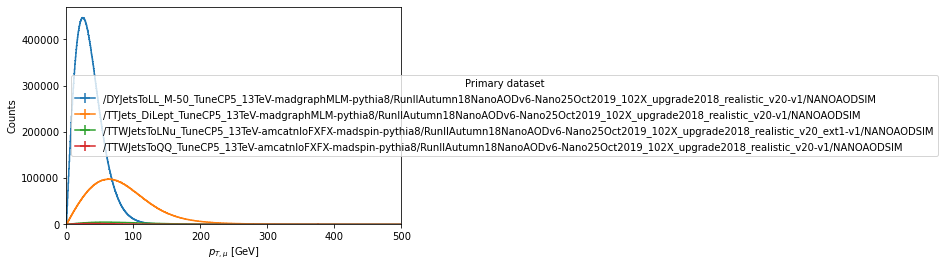

In [158]:
## This is what comes out of the box from coffea. Clearly, proper weights are missing.

histogram = output['MET_pt']

ax = hist.plot1d(histogram,overlay="dataset", stack=False)


In [159]:
# load the config and the cache
from Tools.config_helpers import *
cfg = loadConfig()

In [160]:
## Define categories. Should make that regex at some point
categories = {
    'DY': [ sample for sample in sample_list if sample.count('DYJets')>0 ],
    'TT': [ sample for sample in sample_list if sample.count('TTJets')>0 ],
    'TTW': [ sample for sample in sample_list if sample.count('TTWJets')>0 ],
}

my_labels = {
    categories['DY'][0]: 'Drell-Yan',
    categories['TT'][0]: r'$t\bar{t}$',
    categories['TTW'][0]: r'$t\bar{t}W$',
    categories['TTW'][1]: r'$t\bar{t}W$',
}

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0 or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.5,1.5)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

signal_err_opts = {
    'linestyle':'-',
    'color':'crimson',
    'elinewidth': 1,
}

error_opts = {
    'label': 'uncertainty',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 1.0
}

DY
TT
TTW


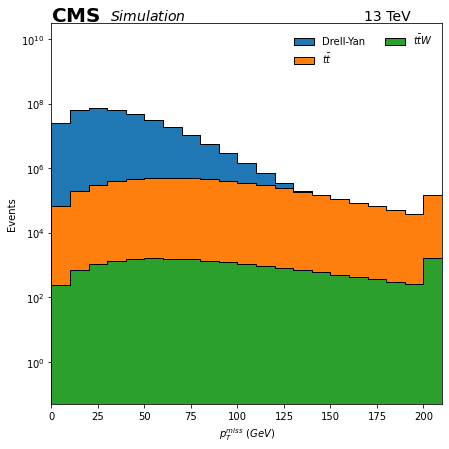

In [161]:
#from plots.helpers import *
bins = {\
    'MET_pt':   {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T^{miss} \ (GeV)$', 20, 0, 200)},
    }

plotDir = os.path.expandvars(cfg['meta']['plots']) + '/dump/'
finalizePlotDir(plotDir)

name = 'MET_pt'

import copy

histogram = copy.deepcopy(output[name])

## Scale
scales = { sample: 137*1000*samples[sample]['xsec']/samples[sample]['sumWeight'] for sample in sample_list }
histogram.scale(scales, axis='dataset')

## Rebin
axis = bins[name]['axis']
histogram = histogram.rebin(axis, bins[name]['bins'])

## Merge. This is still rather stupid, but ok.
for cat in categories:
    print (cat)
    if len(categories[cat])>1:
        for sample in categories[cat][1:]:
            histogram[categories[cat][0]].add(histogram[sample])
            histogram = histogram.remove([sample], 'dataset')

fig, ax = plt.subplots(1,1,figsize=(7,7))

# get axes
hist.plot1d(histogram,overlay="dataset", ax=ax, stack=False, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=sample_list.reverse()) #error_opts??

saveFig(fig, ax, None, plotDir, name, scale='log', shape=False, y_max=100000000)

In [189]:
cluster.close()